# To-do:
# Clean AP_HI and AP_LO Dataset (Done)
# Convert Age from days to years (Done)
# Correlation between datas
# ML models

In [58]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
sb.set() 

In [59]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [60]:
nRowsRead = None # specify 'None' if want to read whole file
# cardio_train.csv has 70000 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('cardio_train.csv', delimiter=';', nrows = nRowsRead)
df1.dataframeName = 'cardio_train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1

There are 70000 rows and 13 columns


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [61]:
#cardio_csv = pd.read_csv('cardio_train.csv', sep=';')
#cardio_csv.shape

In [62]:
print("Data Type: ", type(df1))
print(df1.dtypes)

Data Type:  <class 'pandas.core.frame.DataFrame'>
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


# BMI

In [63]:
df1['BMI'] = ((df1['weight']/(df1['height'] * df1['height'])) * 10000).round(decimals = 0).astype(np.int64)
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27


# Convert age from days to years

In [64]:
df1['age'] = df1['age'].apply(lambda x: x/365).round(decimals = 0).astype(np.int64)
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27


# Clean AP_HI and AP_LO Dataset
## Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) with < 0 value

In [65]:
indexap_hi = df1[df1['ap_hi'] < 0].index
indexap_lo = df1[df1['ap_lo'] < 0].index
#print(indexNames)
df1.drop(indexap_hi , inplace=True)
df1.drop(indexap_lo , inplace=True)
#df1 = df1.drop(df1[df1.ap_hi < 115].index)

In [66]:
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,22
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,35
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,24
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,29
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,27
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27


# Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) that is way more/less than human threshold

### The threshold is determined by low blood pressure (AP_HI < 90mmHg or AP_LO < 60mmHG) and hypertensive crisis (AP_HI > 180mmHg or/and AP_LO > 120mmHG
#  It may be best to assume some AP_HI threshold between 75 to 200. Thus, rows that <75 and >200 are dropped

In [67]:
indexap_hi = df1[df1['ap_hi'] < 75].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_hi'] > 200].index
df1.drop(indexap_hi , inplace=True)

#df1.drop(indexap_lo , inplace=True)

In [68]:
#df1

#  It may be best to assume some AP_HI threshold between 45 to 140. Thus, rows that are <45 or >140 will be dropped

In [69]:
indexap_hi = df1[df1['ap_lo'] < 45].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_lo'] > 140].index
df1.drop(indexap_hi , inplace=True)

In [70]:
indexap_hi = df1[df1['ap_lo'] > df1['ap_hi']].index
df1.drop(indexap_hi,inplace = True)

In [71]:
int64_items = pd.DataFrame(df1.select_dtypes(include = 'int64', exclude = None))
float64_items = pd.DataFrame(df1.select_dtypes(include = 'float64', exclude = None))

In [72]:
#df1

In [73]:
df1.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000
mean,49977.556029,53.325384,1.348518,164.360297,74.111044,126.602691,81.284669,1.364291,1.225528,0.087960,0.053339,0.803364,0.494453,27.512223
std,28846.318762,6.768683,0.476505,8.182716,14.325035,16.489761,9.347154,0.678677,0.571435,0.283239,0.224710,0.397457,0.499973,6.058686
min,0.000000,30.000000,1.000000,55.000000,11.000000,80.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,25006.500000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000
50%,50012.000000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000
75%,74876.500000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,200.000000,140.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,299.000000


In [74]:
age = pd.DataFrame(int64_items["age"])
age.describe()

,age
count,68599.000000
mean,53.325384
std,6.768683
min,30.000000
25%,48.000000
50%,54.000000
75%,58.000000
max,65.000000


<AxesSubplot:>

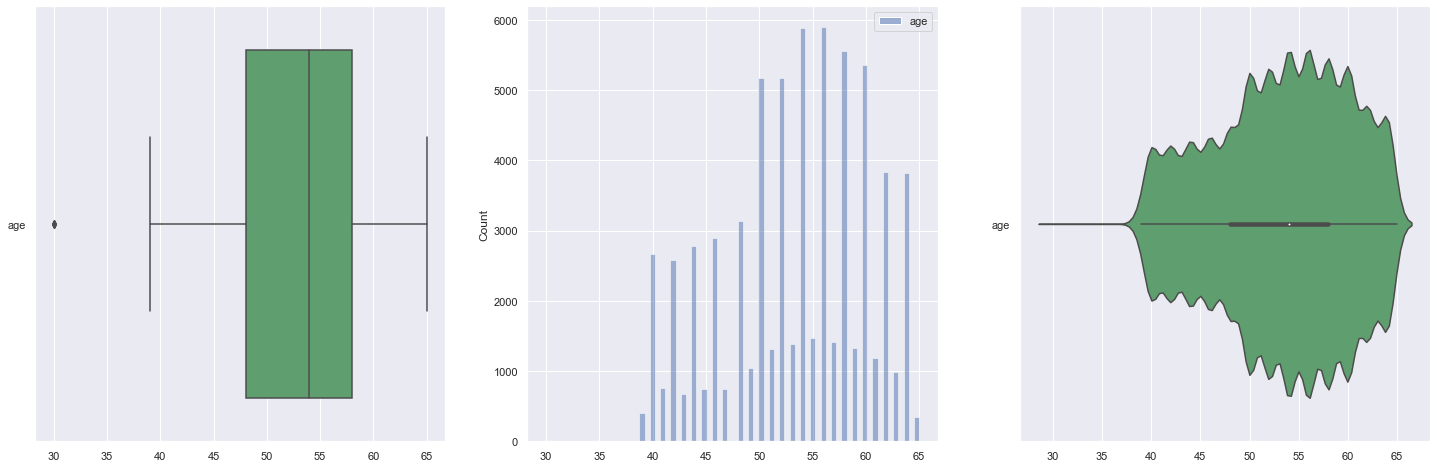

In [75]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = age, orient = "h", color = "g", ax = axes[0])
sb.histplot(data=age, color = "g", ax = axes[1])
sb.violinplot(data=age, orient='h', color = "g", ax = axes[2])

In [76]:
gender = pd.DataFrame(int64_items["gender"])
gender.describe()

,gender
count,68599.000000
mean,1.348518
std,0.476505
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [77]:
gender["gender"] = gender["gender"].replace({1:'Female', 2:"Male"}) #Cleaning gender dataset
gender

,gender
0,Male
1,Female
2,Female
3,Male
4,Female
...,...
69995,Male
69996,Female
69997,Male
69998,Female


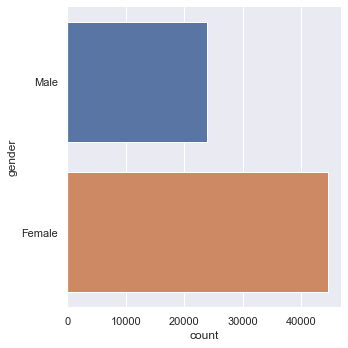

<Figure size 1728x288 with 0 Axes>

In [78]:
sb.catplot(y = 'gender', data = gender, kind = "count")
f = plt.figure(figsize = (24,4))

In [79]:
height = pd.DataFrame(int64_items["height"])
height.describe()

,height
count,68599.000000
mean,164.360297
std,8.182716
min,55.000000
25%,159.000000
50%,165.000000
75%,170.000000
max,250.000000


<AxesSubplot:>

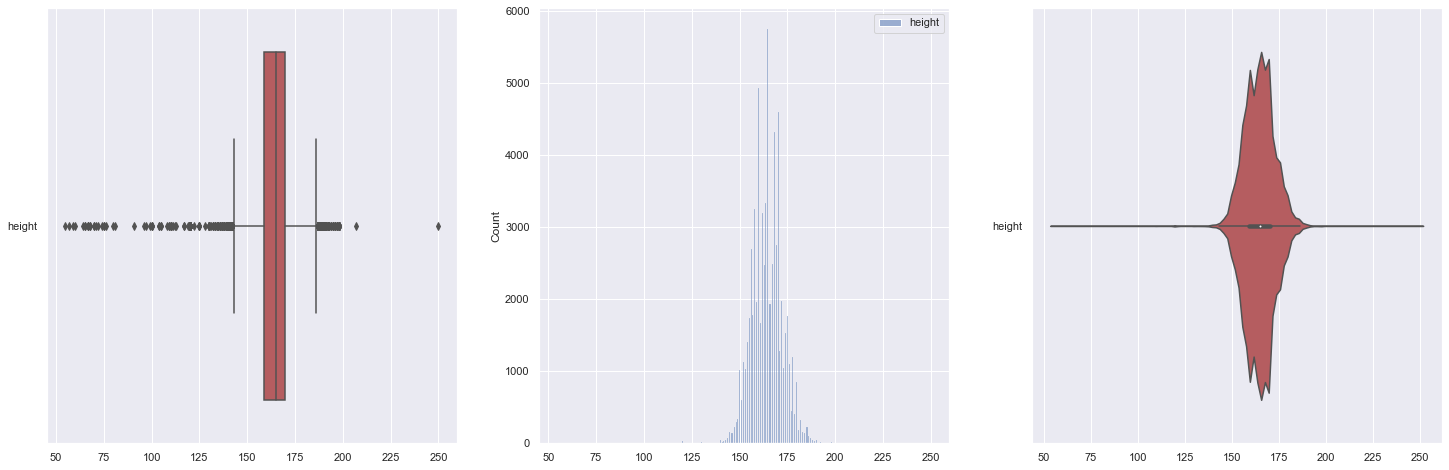

In [80]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = height, orient = "h", color = "r", ax = axes[0])
sb.histplot(data= height, color = "r", ax = axes[1])
sb.violinplot(data= height, orient='h', color = "r", ax = axes[2])

In [81]:
weight = pd.DataFrame(float64_items["weight"])
weight.describe()

,weight
count,68599.000000
mean,74.111044
std,14.325035
min,11.000000
25%,65.000000
50%,72.000000
75%,82.000000
max,200.000000


<AxesSubplot:>

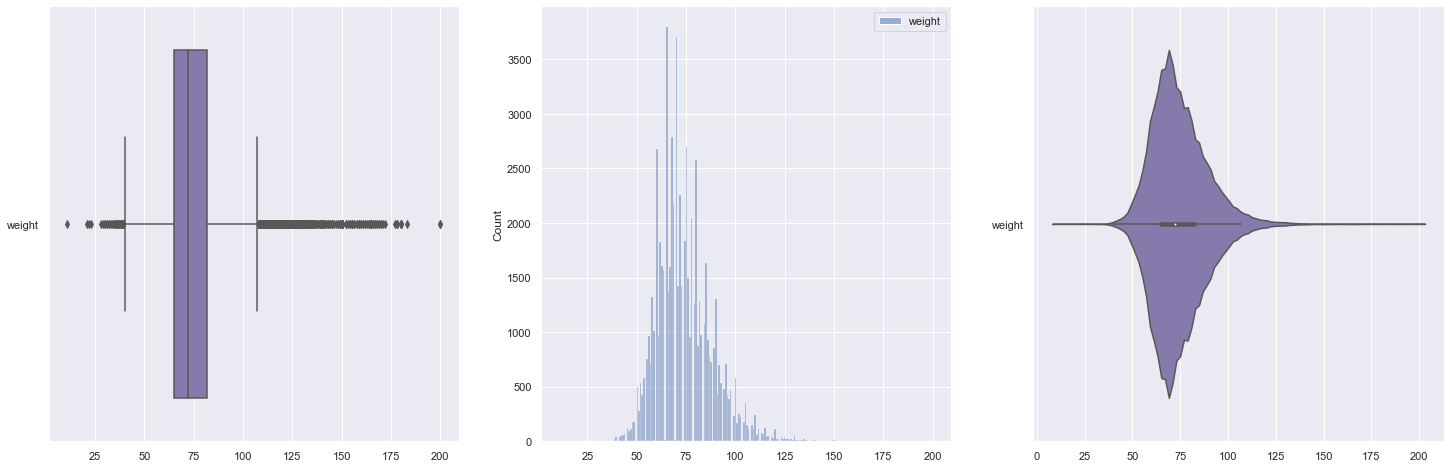

In [82]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = weight, orient = "h", color = "m", ax = axes[0])
sb.histplot(data= weight, color = "m", ax = axes[1])
sb.violinplot(data= weight, orient='h', color = "m", ax = axes[2])

# BMI

In [83]:
bmi = pd.DataFrame(int64_items["BMI"])

In [84]:
bmi.describe()

,BMI
count,68599.000000
mean,27.512223
std,6.058686
min,3.000000
25%,24.000000
50%,26.000000
75%,30.000000
max,299.000000


<AxesSubplot:>

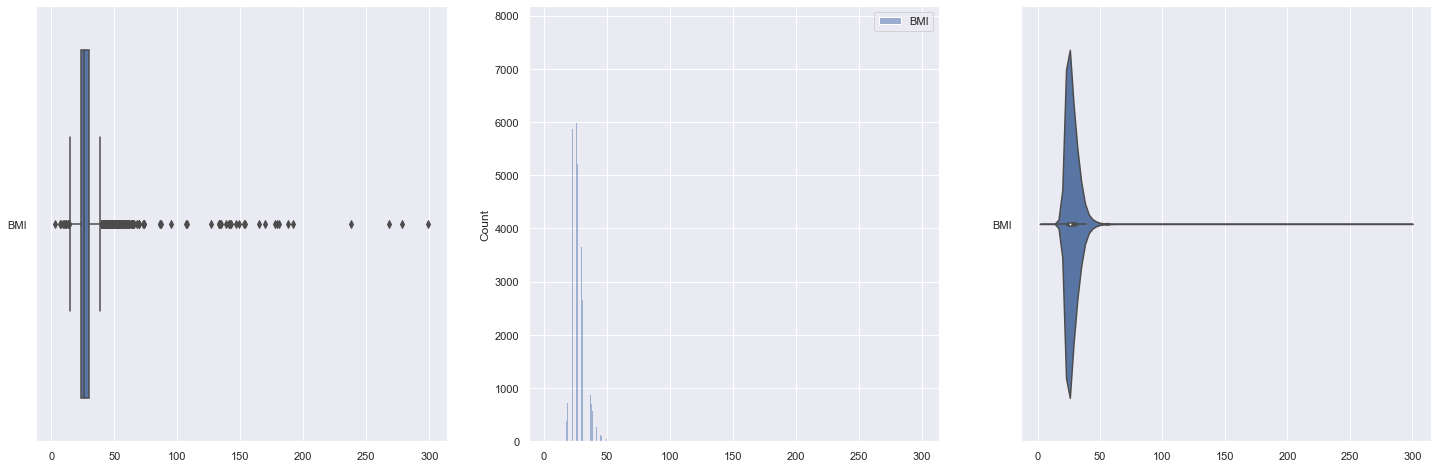

In [85]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = bmi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= bmi, color = "b", ax = axes[1])
sb.violinplot(data= bmi, orient='h', color = "b", ax = axes[2])

# AP_HI is Systolic blood pressure

In [86]:
ap_hi = pd.DataFrame(int64_items["ap_hi"])
ap_hi.describe()

,ap_hi
count,68599.000000
mean,126.602691
std,16.489761
min,80.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,200.000000


<AxesSubplot:>

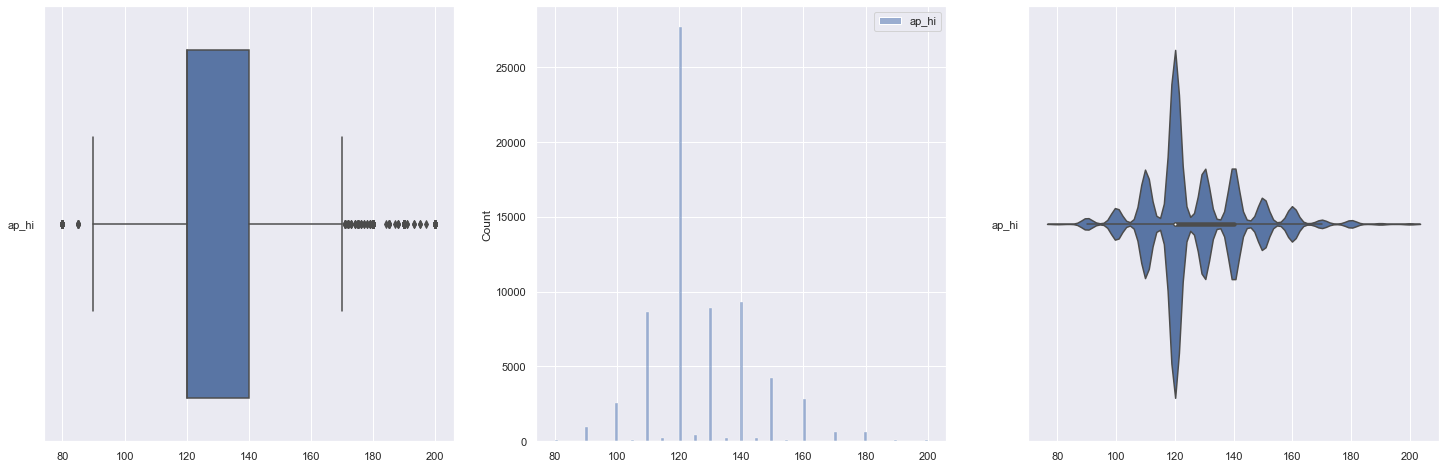

In [87]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_hi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= ap_hi, color = "b", ax = axes[1])
sb.violinplot(data= ap_hi, orient='h', color = "b", ax = axes[2])

# AP_LO is Diastolic blood pressure 

In [88]:
ap_lo = pd.DataFrame(int64_items["ap_lo"])
ap_lo.describe()

,ap_lo
count,68599.000000
mean,81.284669
std,9.347154
min,45.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,140.000000


<AxesSubplot:>

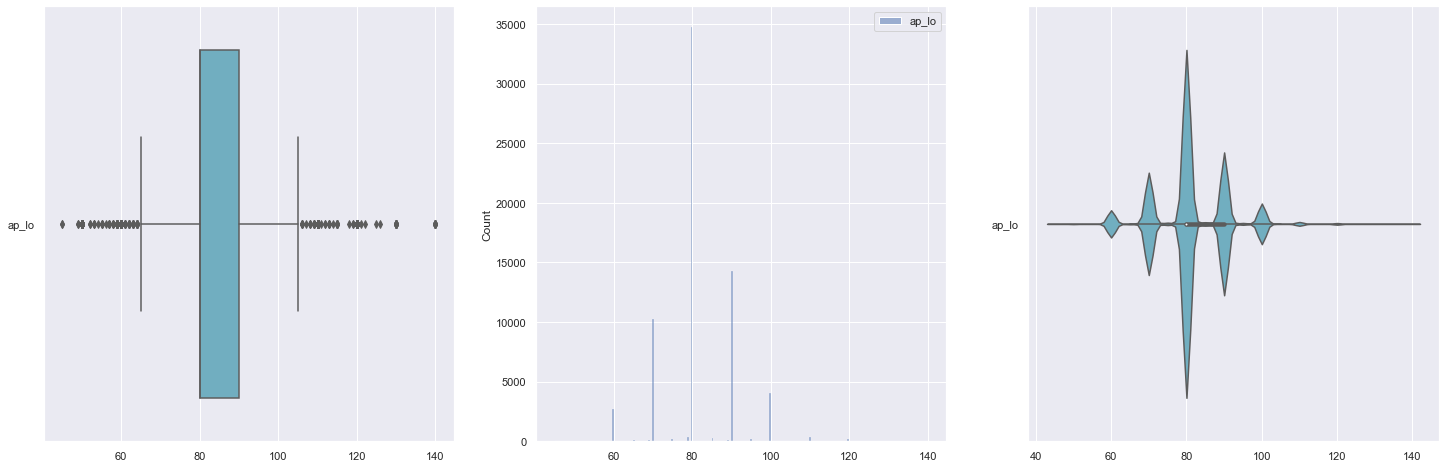

In [89]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_lo, orient = "h", color = "c", ax = axes[0])
sb.histplot(data= ap_lo, color = "c", ax = axes[1])
sb.violinplot(data= ap_lo, orient='h', color = "c", ax = axes[2])

In [90]:
cholesterol = pd.DataFrame(int64_items["cholesterol"])
cholesterol.describe()

,cholesterol
count,68599.000000
mean,1.364291
std,0.678677
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [91]:
cholesterol["cholesterol"] = cholesterol["cholesterol"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning cholesterol dataset
cholesterol

,cholesterol
0,Normal
1,Well above normal
2,Well above normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Well above normal
69998,Normal


No. of categories in cholesterol: 3
Normal               51464
Above Normal          9280
Well above normal     7855
Name: cholesterol, dtype: int64


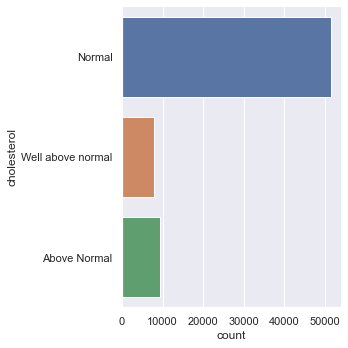

<Figure size 1728x288 with 0 Axes>

In [92]:
# Count of categories for variable "cholesterol"
print("No. of categories in cholesterol:", len(cholesterol["cholesterol"].unique()))
print(cholesterol["cholesterol"].value_counts())

sb.catplot(y = 'cholesterol', data = cholesterol, kind = "count")
f = plt.figure(figsize = (24,4))

In [93]:
glucose = pd.DataFrame(int64_items["gluc"])
glucose.describe()

,gluc
count,68599.000000
mean,1.225528
std,0.571435
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [94]:
glucose["gluc"] = glucose["gluc"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning glucose dataset
glucose

,gluc
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Normal
69998,Above Normal


No. of categories in gluc : 3
Normal               58337
Well above normal     5209
Above Normal          5053
Name: gluc, dtype: int64


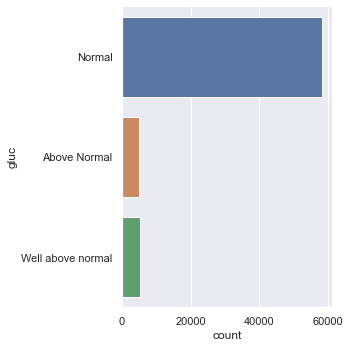

<Figure size 1728x288 with 0 Axes>

In [95]:
# Count of categories for variable "gluc"
print("No. of categories in gluc :", len(glucose["gluc"].unique()))
print(glucose["gluc"].value_counts())

sb.catplot(y = 'gluc', data = glucose, kind = "count")
f = plt.figure(figsize = (24,4))

In [96]:
smoke = pd.DataFrame(int64_items["smoke"])
smoke.describe()

,smoke
count,68599.000000
mean,0.087960
std,0.283239
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [97]:
smoke["smoke"] = smoke["smoke"].replace({1:"Yes", 0:"No"}) #Cleaning smoke dataset
smoke

,smoke
0,No
1,No
2,No
3,No
4,No
...,...
69995,Yes
69996,No
69997,No
69998,No


No. of categories in smoke : 2
No     62565
Yes     6034
Name: smoke, dtype: int64


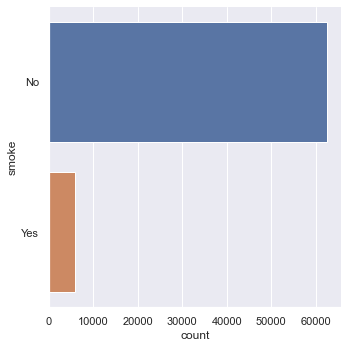

<Figure size 1728x288 with 0 Axes>

In [98]:
# Count of categories for variable "smoke"
print("No. of categories in smoke :", len(smoke["smoke"].unique()))
print(smoke["smoke"].value_counts())

sb.catplot(y = 'smoke', data = smoke, kind = "count")
f = plt.figure(figsize = (24,4))

In [99]:
alcohol = pd.DataFrame(int64_items["alco"])
alcohol.describe()

,alco
count,68599.000000
mean,0.053339
std,0.224710
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [100]:
alcohol["alco"] = alcohol["alco"].replace({1:"Yes", 0:"No"}) #Cleaning alcohol dataset
alcohol

,alco
0,No
1,No
2,No
3,No
4,No
...,...
69995,No
69996,No
69997,Yes
69998,No


No. of categories in alco : 2
No     64940
Yes     3659
Name: alco, dtype: int64


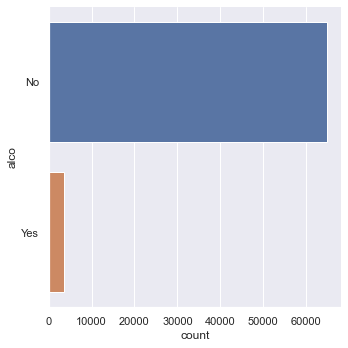

<Figure size 1728x288 with 0 Axes>

In [101]:
# Count of categories for variable "alco"
print("No. of categories in alco :", len(alcohol["alco"].unique()))
print(alcohol["alco"].value_counts())

sb.catplot(y = 'alco', data = alcohol, kind = "count")
f = plt.figure(figsize = (24,4))

In [102]:
physical_Activity = pd.DataFrame(int64_items["active"])
physical_Activity.describe()

,active
count,68599.000000
mean,0.803364
std,0.397457
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [103]:
physical_Activity["active"] = physical_Activity["active"].replace({1:"Yes", 0:"No"}) #Cleaning physical activity dataset
physical_Activity

,active
0,Yes
1,Yes
2,No
3,Yes
4,No
...,...
69995,Yes
69996,Yes
69997,No
69998,No


No. of categories in active : 2
Yes    55110
No     13489
Name: active, dtype: int64


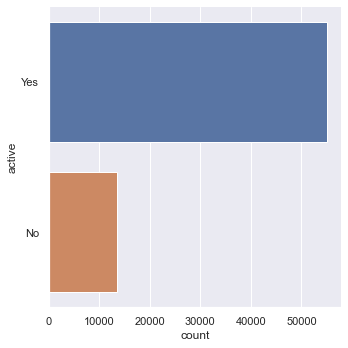

<Figure size 1728x288 with 0 Axes>

In [104]:
# Count of categories for variable "active"
print("No. of categories in active :", len(physical_Activity["active"].unique()))
print(physical_Activity["active"].value_counts())

sb.catplot(y = 'active', data = physical_Activity, kind = "count")
f = plt.figure(figsize = (24,4))

In [105]:
cardio = pd.DataFrame(int64_items["cardio"])
cardio.describe()

,cardio
count,68599.000000
mean,0.494453
std,0.499973
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [106]:
cardio["cardio"] = cardio["cardio"].replace({1:"Yes", 0:"No"}) #Cleaning presence of cardiovascular disease dataset
cardio

,cardio
0,No
1,Yes
2,Yes
3,Yes
4,No
...,...
69995,No
69996,Yes
69997,Yes
69998,Yes


No. of categories in cardio : 2
No     34680
Yes    33919
Name: cardio, dtype: int64


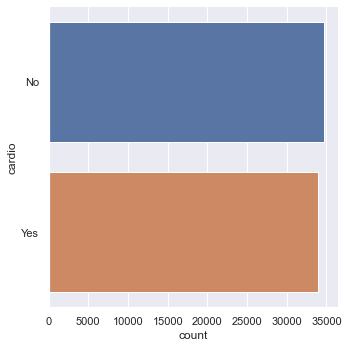

<Figure size 1728x288 with 0 Axes>

In [107]:
# Count of categories for variable "cardio"
print("No. of categories in cardio :", len(cardio["cardio"].unique()))
print(cardio["cardio"].value_counts())

sb.catplot(y = 'cardio', data = cardio, kind = "count")
f = plt.figure(figsize = (24,4))

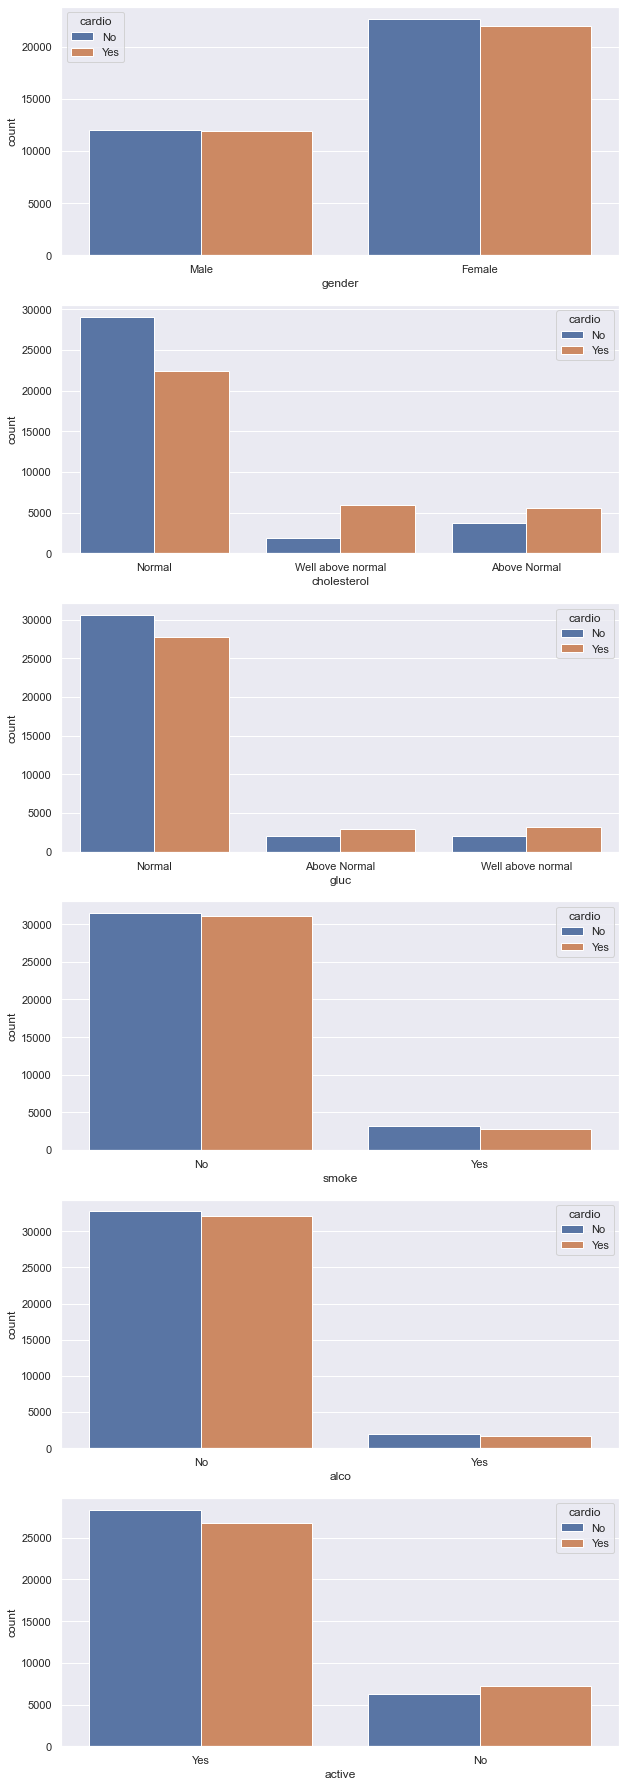

In [108]:
visual = gender
arr = [cholesterol,glucose,smoke,alcohol,physical_Activity,cardio]
for i in arr:
    visual = pd.concat([visual,i],axis = 1)

f,axes = plt.subplots(6,figsize = (10,32))
catvar = ['gender','cholesterol','gluc','smoke','alco','active']
count = 0
for i in catvar:
    sb.countplot(data = visual, x = visual[i] , hue = "cardio", ax = axes[count])
    count+=1

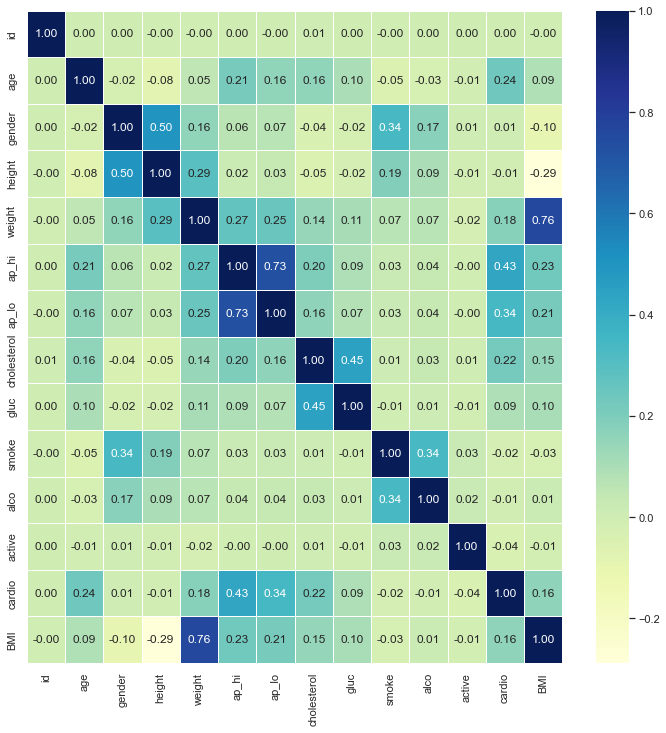

In [110]:
df1_corr_matrix = df1.corr()
fig = plt.subplots(figsize=(12, 12))
sb.heatmap(df1_corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu");

# Brief Analysis:

We've cleaned and prepared our dataset, and have done a basic exploratory analysis and statstical visualisation of variables. Our numeric type variables include age, height, weight, AP_HI (systolic BP) and AP_LO (diastolic BP). As part of data preparation and cleaning, we've converted age in days to age in years and combined height and weight factors into a single new variable, i.e. BMI and added it to our dataset. Moreover, a range of AP_HI and AP_LO has been selected from all 70000 rows to rule out outliers for the time-being. 

Our categorical variables include cholesterol, glucose, alcohol, smoke, physical activity, and most importantly, cardio which tells whether a given patient is affected/not by cardiovascular diseases.

# (Rough) Problem statement:

1) How do all the variables stated above relate with likeliness of cardiovascular diseases in people? Which are the strongest/best indicators of having a cardiovascular disease (most accurate correlation)?

2) Based on 1, which of the indicators strongly predict likeliness of strokes as well? (another dataset can be imported here)

Thus, drawing a connection between cardiovascular and stroke likeliness.

Now, for the prediction models. First, we explore simple decision trees with individual pairs of variables before moving on to multi-variate and more complicated classification.



# Method I: Simple Individual Classification Decision Trees 

# A) Numeric variables

# I) cardio vs age

In [51]:
# cardio is response, age is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
age_train, age_test, cardio_train, cardio_test = train_test_split(age, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, age_train.shape)
print("Test Set  :", cardio_test.shape, age_test.shape)


Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


In [52]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree Classifier object
dectree1 = DecisionTreeClassifier(max_depth = 5)

# Train the Decision Tree Classifier model
dectree1.fit(age_train, cardio_train)

DecisionTreeClassifier(max_depth=5)

<AxesSubplot:xlabel='age', ylabel='cardio'>

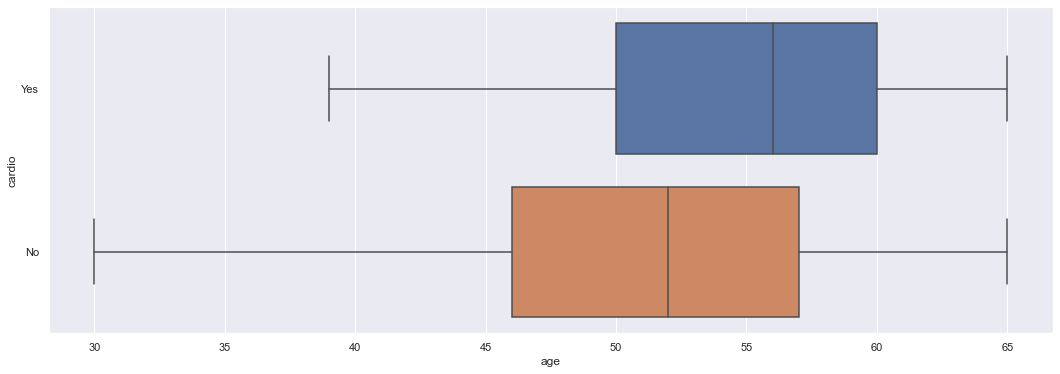

In [53]:
# train data
# Joint dataframe concatenating age and cardio
trainDF1 = pd.concat([age_train, cardio_train], axis = 1).reindex(age_train.index)

# Joint Boxplot of age train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "age", y = "cardio", data = trainDF1, orient = "h")

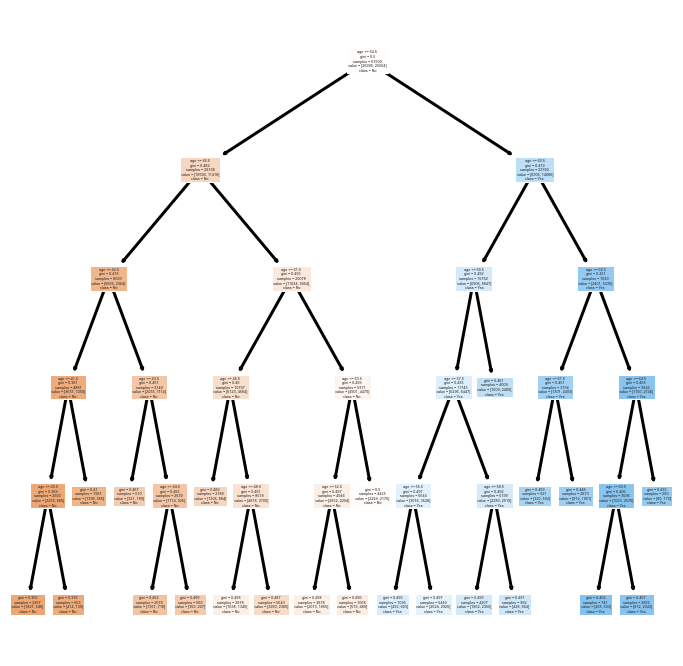

In [54]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree1, 
          feature_names = age_train.columns,
          class_names = [str(x) for x in dectree1.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

Classification Accuracy 	: 0.5017864077669902


<AxesSubplot:>

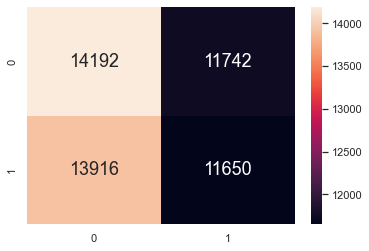

In [57]:
# Predicting cardio corresponding to age train
cardio_train_pred = dectree1.predict(age_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Classification Accuracy 	: 0.5061455117376361


<AxesSubplot:>

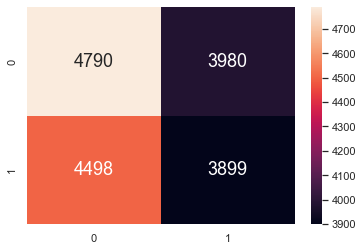

In [58]:
# now for test data
# Predicting cardio corresponding to age test
cardio_test_pred = dectree1.predict(age_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree1.score(age_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# II) cardio vs BMI

In [56]:
# cardio is response, bmi is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
bmi_train, bmi_test, cardio_train, cardio_test = train_test_split(bmi, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, bmi_train.shape)
print("Test Set  :", cardio_test.shape, bmi_test.shape)

# train data
# Joint dataframe concatenating bmi and cardio
trainDF2 = pd.concat([bmi_train, cardio_train], axis = 1).reindex(bmi_train.index)

# Joint Boxplot of bmi train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "bmi", y = "cardio", data = trainDF2, orient = "h")

# Joint Swarmplot of bmi Train against cardio Train
f = plt.figure(figsize=(18, 6))
sb.swarmplot(x = "bmi", y = "cardio", data = trainDF2, orient = "h")

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree2 = DecisionTreeClassifier(max_depth = 2)

# Train the Decision Tree Classifier model
dectree2.fit(bmi_train, cardio_train)

from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree2, 
          feature_names = bmi_train.columns,
          class_names = [str(x) for x in dectree2.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

# Predicting cardio corresponding to bmi train
cardio_train_pred = dectree2.predict(bmi_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree2.score(bmi_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# now for test data
# Predicting cardio corresponding to bmi test
cardio_test_pred = dectree2.predict(bmi_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree2.score(bmi_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Train Set : (51500, 1) (51500, 1)
Test Set  : (17167, 1) (17167, 1)


ValueError: Could not interpret input 'bmi'

<Figure size 1296x432 with 0 Axes>

# III) cardio vs AP_LO

In [ ]:
# cardio is response, AP_LO is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
ap_lo_train, ap_lo_test, cardio_train, cardio_test = train_test_split(ap_lo, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, ap_lo_train.shape)
print("Test Set  :", cardio_test.shape, ap_lo_test.shape)

# train data
# Joint dataframe concatenating AP_LO and cardio
trainDF3 = pd.concat([ap_lo_train, cardio_train], axis = 1).reindex(ap_lo_train.index)

# Joint Boxplot of AP_LO train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "ap_lo", y = "cardio", data = trainDF3, orient = "h")

# Joint Swarmplot of AP_LO Train against cardio Train
f = plt.figure(figsize=(18, 6))
sb.swarmplot(x = "ap_lo", y = "cardio", data = trainDF3, orient = "h")

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree3 = DecisionTreeClassifier(max_depth = 2)

# Train the Decision Tree Classifier model
dectree3.fit(ap_lo_train, cardio_train)

from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree3, 
          feature_names = ap_lo_train.columns,
          class_names = [str(x) for x in dectree3.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

# Predicting cardio corresponding to AP_LO train
cardio_train_pred = dectree3.predict(ap_lo_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree3.score(ap_lo_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# now for test data
# Predicting cardio corresponding to AP_LO test
cardio_test_pred = dectree3.predict(ap_lo_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree3.score(ap_lo_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# IV) cardio vs AP_HI

In [ ]:
# cardio is response, AP_HI is predictor, both dataframes declared individually before

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Splitting our dataset into Train and Test
ap_hi_train, ap_hi_test, cardio_train, cardio_test = train_test_split(ap_hi, cardio, test_size = 0.25)


# Check the sample sizes
print("Train Set :", cardio_train.shape, ap_hi_train.shape)
print("Test Set  :", cardio_test.shape, ap_hi_test.shape)

# train data
# Joint dataframe concatenating AP_HI and cardio
trainDF4 = pd.concat([ap_hi_train, cardio_train], axis = 1).reindex(ap_hi_train.index)

# Joint Boxplot of AP_HI train against cardio train
f = plt.figure(figsize=(18, 6))
sb.boxplot(x = "ap_hi", y = "cardio", data = trainDF4, orient = "h")

# Joint Swarmplot of AP_HI Train against cardio Train
f = plt.figure(figsize=(18, 6))
sb.swarmplot(x = "ap_hi", y = "cardio", data = trainDF4, orient = "h")

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree4 = DecisionTreeClassifier(max_depth = 2)

# Train the Decision Tree Classifier model
dectree4.fit(ap_hi_train, cardio_train)

from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree4, 
          feature_names = ap_hi_train.columns,
          class_names = [str(x) for x in dectree4.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

# Predicting cardio corresponding to AP_HI train
cardio_train_pred = dectree4.predict(ap_hi_train)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree4.score(ap_hi_train, cardio_train))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# now for test data
# Predicting cardio corresponding to AP_HI test
cardio_test_pred = dectree4.predict(ap_hi_test)

# Printing the Classification Accuracy
print("Classification Accuracy \t:", dectree4.score(ap_hi_test, cardio_test))

# Plotting the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Multi-Variate Classification

In [61]:
int64_items

,id,age,gender,height,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,168,110,80,1,1,0,0,1,0,22
1,1,55,1,156,140,90,3,1,0,0,1,1,35
2,2,52,1,165,130,70,3,1,0,0,0,1,24
3,3,48,2,169,150,100,1,1,0,0,1,1,29
4,4,48,1,156,100,60,1,1,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,120,80,1,1,1,0,1,0,27
69996,99995,62,1,158,140,90,2,2,0,0,1,1,50
69997,99996,52,2,183,180,90,3,1,0,1,0,1,31
69998,99998,61,1,163,135,80,1,2,0,0,0,1,27


In [62]:
# Extract Response and Predictors
# cardio is response, all the other numeric variables (saved in dataframe X) are predictors

X = pd.DataFrame(int64_items[["age", "BMI", "ap_lo", "ap_hi"]])

# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X, cardio, test_size = 0.25)

# Check the sample sizes
print("Train Set :", cardio_train.shape, X_train.shape)
print("Test Set  :", cardio_test.shape, X_test.shape)


Train Set : (51500, 1) (51500, 4)
Test Set  : (17167, 1) (17167, 4)


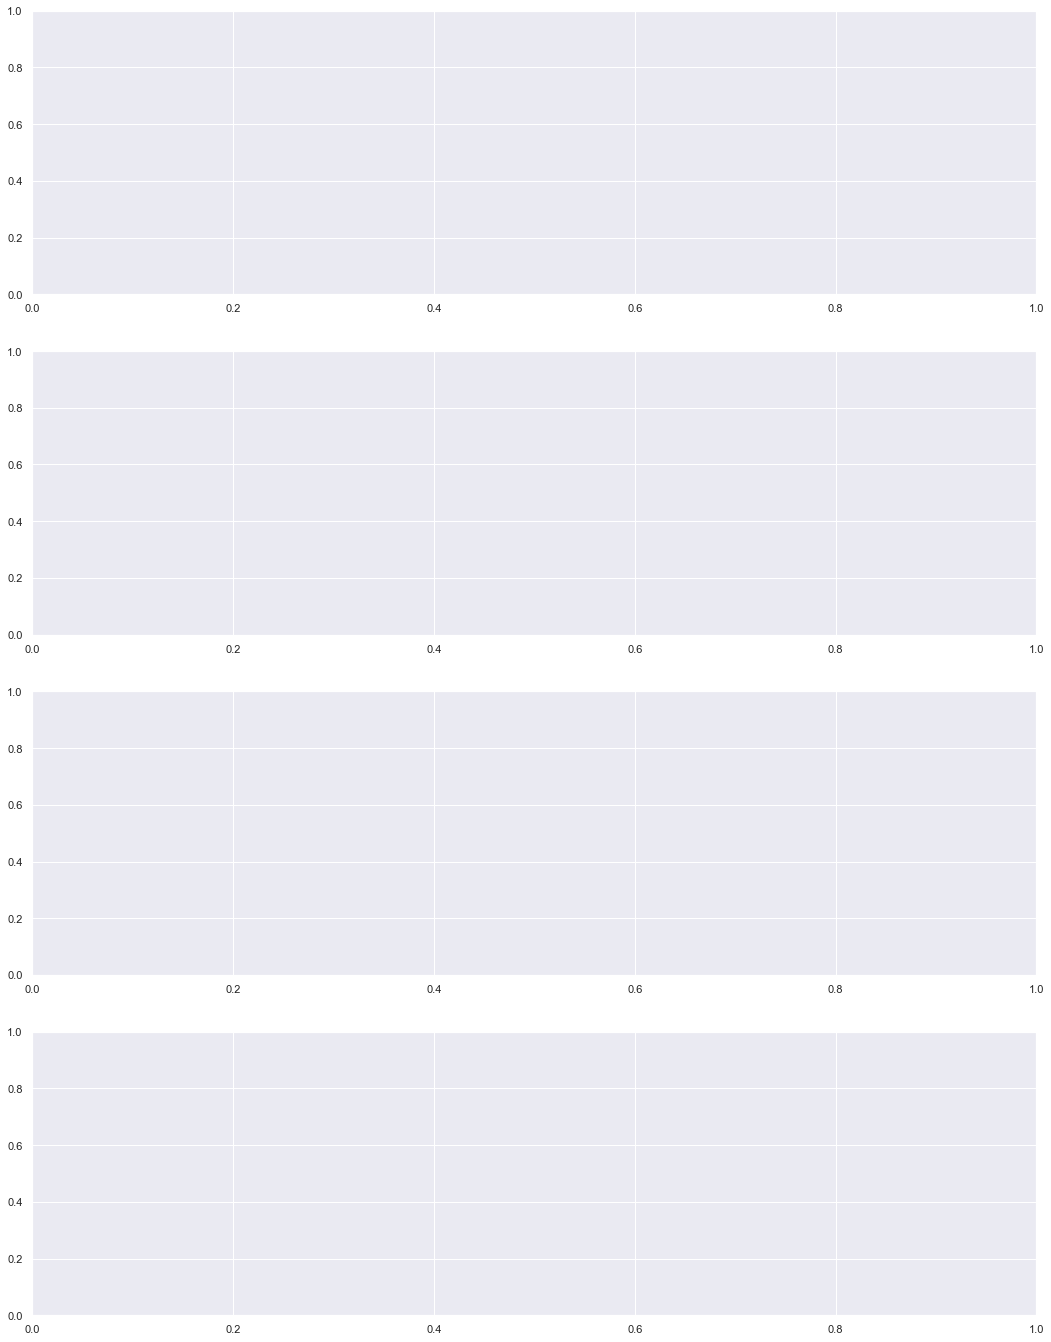

In [63]:
# Relationship between Response and the Predictors
trainDF = pd.concat([cardio_train, X_train], axis = 1).reindex(cardio_train.index)

f, axes = plt.subplots(4, 1, figsize=(18, 24))


In [ ]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, cardio_train)                    # train the decision tree model

# Plot the trained Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

# Predict Legendary values corresponding to Total
cardio_train_pred = dectree.predict(X_train)
cardio_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, cardio_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, cardio_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(cardio_train, cardio_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(cardio_test, cardio_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Logistic Regression

In [113]:
from sklearn.model_selection import train_test_split
X = df1[["age", "BMI", "ap_lo", "ap_hi","cholesterol"]]
# Splitting the Dataset into Train and Test
X_train, X_test, cardio_train, cardio_test = train_test_split(X,df1["cardio"], test_size = 0.25)

In [114]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(solver = "lbfgs")
LogReg.fit(X_train,cardio_train)

LogisticRegression()

In [115]:
cardio_train_predict = LogReg.predict(X_train)
cardio_test_predict = LogReg.predict(X_test)

In [116]:
logregtrainacc = (LogReg.score(X_train,cardio_train)*100).round(2)
logregtestacc = (LogReg.score(X_test,cardio_test)*100).round(2)

print("Training data's accuracy:", logregtrainacc)
print("Test data's accuracy:", logregtestacc)

Training data's accuracy: 72.54
Test data's accuracy: 72.28


<AxesSubplot:>

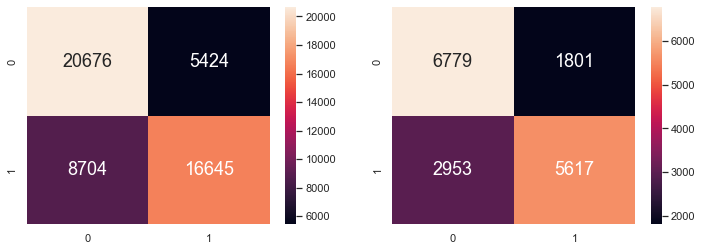

In [118]:
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(cardio_train, cardio_train_predict),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(cardio_test, cardio_test_predict), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])